In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import itertools
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns


In [2]:
df = pd.read_csv('wind.csv', parse_dates=['datetime'], index_col=['datetime'])
df.head()

,airtemp,pressure,windspeed,winddir,powergen
datetime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


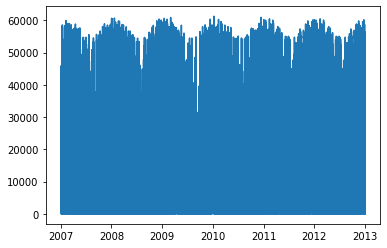

In [3]:
plt.plot(df['powergen'])
plt.show()

In [4]:
df1 = df.asfreq(freq='D', method='ffill')
df1.head()

,airtemp,pressure,windspeed,winddir,powergen
datetime,,,,,
2007-01-01,10.926,0.979103,9.014,229,33688.10
2007-01-02,3.621,0.987624,9.166,329,35393.60
2007-01-03,3.956,0.991080,4.110,71,1661.72
2007-01-04,6.091,0.988491,6.660,166,13287.50
2007-01-05,15.448,0.979178,9.420,156,35604.40


In [5]:
rolmean = df1['powergen'].rolling(window=2).mean()

rolstd = df1['powergen'].rolling(window=2).std()

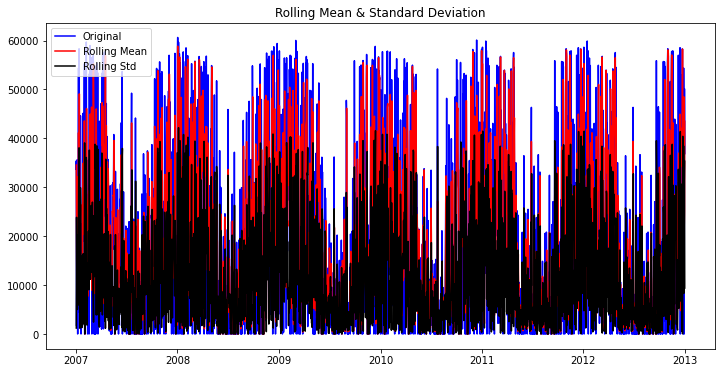

In [6]:
plt.figure(figsize=(12,6))
orig = plt.plot(df1['powergen'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

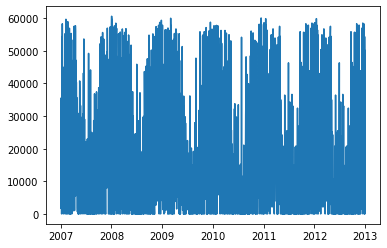

In [7]:
plt.plot(df1['powergen'])
plt.show()


In [8]:
df1 = df1['powergen'].resample('MS').mean()
df1

datetime
2007-01-01    23970.714194
2007-02-01    25134.592143
2007-03-01    25069.143677
2007-04-01    28542.508033
2007-05-01    16068.226548
                  ...     
2012-08-01     5603.378645
2012-09-01    11466.679667
2012-10-01    20766.360774
2012-11-01    25660.908667
2012-12-01    28983.205161
Freq: MS, Name: powergen, Length: 72, dtype: float64

In [9]:
y_train=df1[:len(df1)-11]
y_test= df1[len(df1)-11:]

In [10]:
y_train[-5:]

datetime
2011-09-01    11466.679667
2011-10-01    20766.360774
2011-11-01    25660.908667
2011-12-01    28983.205161
2012-01-01    28128.464516
Freq: MS, Name: powergen, dtype: float64

<AxesSubplot:xlabel='datetime'>

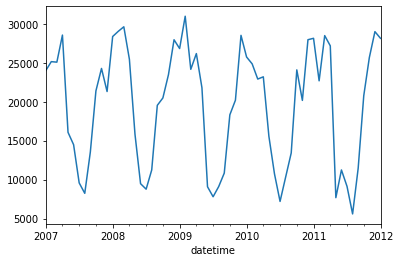

In [11]:
y_train.plot()

<AxesSubplot:xlabel='datetime'>

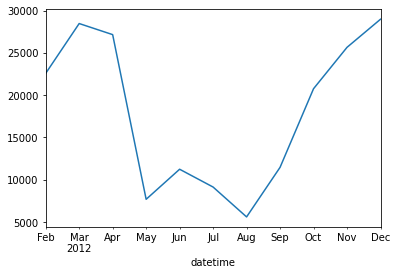

In [12]:
y_test.plot()

In [13]:
result=adfuller(df['powergen'])
print('ADF test statistics: %f' % result[0])
print('p-value: %f' %result[1])
print('critical values: ')

for key,value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF test statistics: -22.954492
p-value: 0.000000
critical values: 
	1%: -3.430
	5%: -2.862
	10%: -2.567


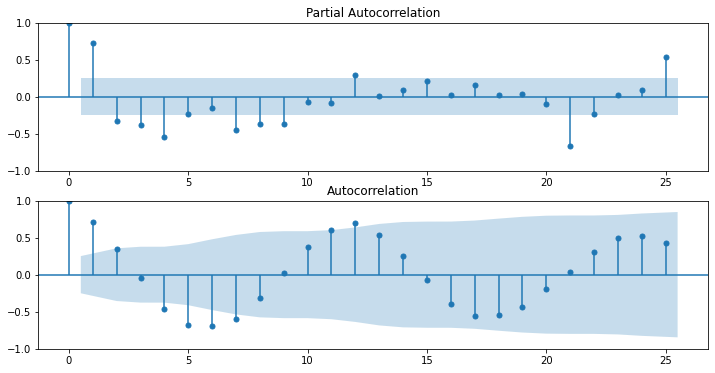

In [18]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = sm.graphics.tsa.plot_pacf(y_train, lags=25, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_acf(y_train, lags=25, ax=ax[1])

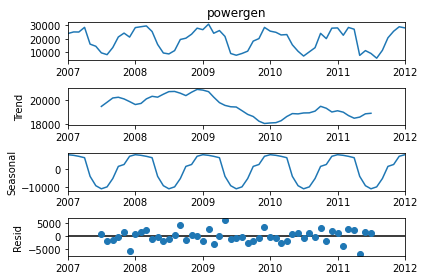

In [19]:
ts_decompose = sm.tsa.seasonal_decompose(y_train, model = 'additive')
ts_decompose.plot()
plt.show()


In [19]:
p = d = q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print('SARIMAX: {} x {}'. format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'. format(pdq[2], seasonal_pdq[2]))
print('SARIMAX: {} x {}'. format(pdq[3], seasonal_pdq[3]))
print('SARIMAX: {} x {}'. format(pdq[4], seasonal_pdq[4]))
print('SARIMAX: {} x {}'. format(pdq[5], seasonal_pdq[5]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 2) x (0, 0, 2, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 2) x (0, 1, 2, 12)


In [21]:
metric_aic_dict= dict()

for pm in pdq:
    for pm_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y_train,
                                             order=pm,
                                             seasonal_order=pm_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model_aic = model.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(pm, pm_seasonal, model_aic.aic))
            metric_aic_dict.update({(pm, pm_seasonal):model_aic.aic})
        except:
            continue
# aic - estimates quality of each model

In [22]:
{k: v for k, v in sorted(metric_aic_dict.items(), key=lambda x: x[1])}

{((0, 2, 2), (0, 1, 1, 12)): 8.0,
 ((0, 2, 1), (2, 1, 1, 12)): 95.06087160638492,
 ((0, 2, 2), (0, 2, 2, 12)): 170.28451799939913,
 ((1, 2, 2), (0, 2, 2, 12)): 170.37568413693936,
 ((2, 2, 2), (0, 2, 2, 12)): 170.9998496750604,
 ((2, 2, 2), (1, 2, 2, 12)): 171.43064080440473,
 ((0, 2, 2), (1, 2, 2, 12)): 171.71578528700798,
 ((1, 2, 2), (1, 2, 2, 12)): 171.75494884375672,
 ((1, 2, 2), (1, 1, 1, 12)): 173.21472898248726,
 ((2, 2, 2), (2, 2, 2, 12)): 173.4309227029919,
 ((0, 2, 2), (2, 2, 2, 12)): 173.66461609731164,
 ((1, 2, 2), (2, 2, 2, 12)): 173.7109021332808,
 ((0, 1, 2), (0, 2, 2, 12)): 184.4340651069697,
 ((1, 1, 2), (0, 2, 2, 12)): 185.15360075508065,
 ((0, 1, 2), (1, 2, 2, 12)): 185.66775233285517,
 ((1, 1, 2), (1, 2, 2, 12)): 186.58661146793048,
 ((2, 1, 2), (0, 2, 2, 12)): 186.66436395516865,
 ((0, 1, 2), (2, 2, 2, 12)): 188.2061874865883,
 ((1, 1, 2), (2, 2, 2, 12)): 188.59122496005472,
 ((2, 1, 2), (1, 2, 2, 12)): 188.61283927358633,
 ((2, 1, 2), (2, 2, 2, 12)): 190.75420284

In [16]:
model = sm.tsa.statespace.SARIMAX(y_train, order=(0,2,2), seasonal_order=(0,1,1,12),enforce_stationarity=False, enforce_invertibility=False)
model_aic = model.fit()
print(model_aic.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -3.9991      0.000  -2.84e+04      0.000      -3.999      -3.999
ma.L2          2.1268      0.006    383.135      0.000       2.116       2.138
ma.S.L12   -1.332e+14         -0        inf      0.000   -1.33e+14   -1.33e+14
sigma2       3.31e+07         -0       -inf      0.000    3.31e+07    3.31e+07


LinAlgError: singular matrix

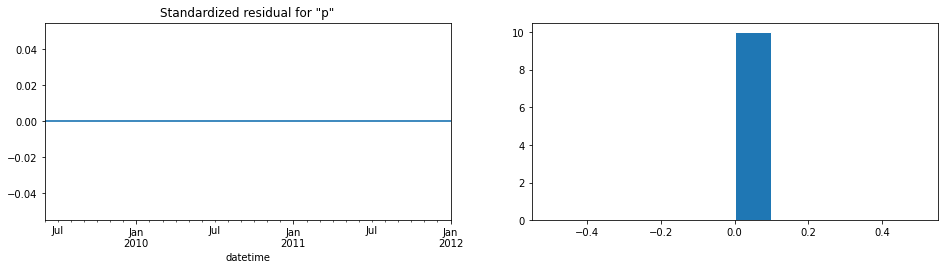

In [17]:
model_aic.plot_diagnostics(figsize=(16,8))
plt.show()

In [20]:
forecast= model_aic.get_prediction(start=pd.to_datetime('2012-02-01'))
predictions = forecast.predicted_mean

actual = y_test['2012-02-01':]

rmse = np.sqrt((predictions - actual) ** 2).mean()
print('the root mean squared error of our forecasts is {}'.format(round(rmse,2)))

the root mean squared error of our forecasts is 49694040959901.92


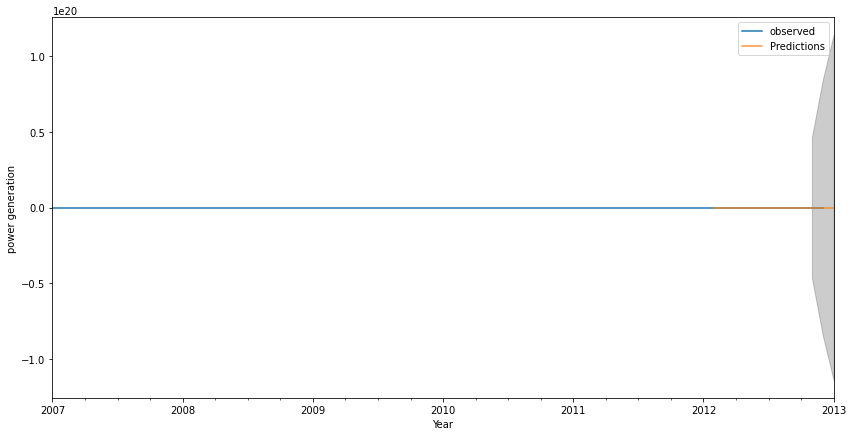

In [21]:
forecast = model_aic.get_forecast(steps=12)

predictions=forecast.predicted_mean
ci = forecast.conf_int()

fig = df1.plot(label='observed', figsize=(14,7))
fig.set_xlabel('Year')
fig.set_ylabel('power generation')
fig.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k' ,alpha=.2)

predictions.plot(ax=fig, label='Predictions', alpha=.8, figsize=(14,7))


plt.legend()
plt.show()


<AxesSubplot:xlabel='datetime'>

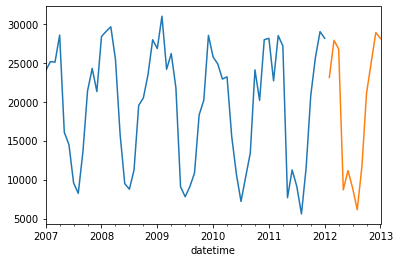

In [41]:
y_train.plot()
predictions.plot()
